# Codeanywhere PyTorch Template: Image Adventures!

Welcome to the exciting world of PyTorch on Codeanywhere! This template is your springboard for creating amazing image classification projects. We'll use the FashionMNIST dataset – think of it as a stylish alternative to the classic MNIST digits – to get you started.

In this interactive notebook, you'll learn how to:

*   **Load a Dataset:** Grab FashionMNIST and prepare it for our fashion-forward model.
*   **Build a Neural Network:** Create a simple but effective network to recognize clothing items.
*   **Train Your Model:** Teach your network to identify different types of clothes with a fun training loop.
*   **Test It Out:** See your model in action by testing it on new images. How well does it perform?

Ready to become an AI fashionista? Let's dive in!

The code is based on the [Pytorch build a model tutorial](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html). You can find more help on the links below:

[Learn the Basics](intro.html) ||
[Quickstart](quickstart_tutorial.html) ||
[Tensors](tensorqs_tutorial.html) ||
[Datasets & DataLoaders](data_tutorial.html) ||
[Transforms](transforms_tutorial.html) ||
**Build Model** ||
[Autograd](autogradqs_tutorial.html) ||
[Optimization](optimization_tutorial.html) ||
[Save & Load Model](saveloadrun_tutorial.html)

# Building the Neural Network

Neural networks are made up of layers/modules that perform operations on data. The [torch.nn](https://pytorch.org/docs/stable/nn.html) namespace provides all the building blocks you need to create your own neural networks. Every module in PyTorch subclasses the [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). A neural network itself is a module consisting of other modules (layers). This nested structure makes it easy to build and manage complex architectures.

In the following sections, we'll build a neural network to classify images in the FashionMNIST dataset.

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random

## Getting a Device
We want to train our model on a hardware accelerator like the GPU, if available. Let's check if [torch.cuda](https://pytorch.org/docs/stable/notes/cuda.html) or [torch.backends.mps](https://pytorch.org/docs/stable/notes/mps.html) are available; otherwise, we'll use the CPU. Codeanywhere may not have GPU support, but we're always looking to improve. Keep an eye out for future updates!


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Defining Our Neural Network
We define our neural network by subclassing `nn.Module` and initializing the neural network layers in `__init__`. Every `nn.Module` subclass implements the operations on input data in the `forward` method.

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Let's create an instance of `NeuralNetwork`, move it to our `device`, and print its structure.

In [5]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


To use the model, we pass it the input data. This executes the model's `forward` method, along with some [background operations](https://github.com/pytorch/pytorch/blob/270111b7b611d174967ed204776985cefca9c144/torch/nn/modules/module.py#L866). Do not call `model.forward()` directly!

Calling the model on the input returns a 2-dimensional tensor with dim=0 corresponding to each output of 10 raw predicted values for each class, and dim=1 corresponding to the individual values of each output. We get the prediction probabilities by passing it through an instance of the `nn.Softmax` module.

In [6]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([5])


## Let's dive deeper...

## Inside the Model Layers

Let's break down the layers in the FashionMNIST model. To illustrate, we'll take a minibatch of 3 images of size 28x28 and see what happens as we pass it through the network.

In [7]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


### nn.Flatten
We initialize the [nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values. The minibatch dimension (at dim=0) is maintained.

In [8]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


### nn.Linear
The [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) is a module that applies a linear transformation on the input using its stored weights and biases.

In [9]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


### nn.ReLU
Non-linear activations create complex mappings between the model's inputs and outputs. They're applied after linear transformations to introduce *nonlinearity*, helping neural networks learn a wide variety of phenomena.

In this model, we use [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) between our linear layers, but there are other activations to introduce non-linearity in your model.

In [10]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 0.1303, -0.5613, -0.3949, -0.6929, -0.1348,  0.1154, -0.2406,  0.3619,
          0.5881,  0.2623,  0.3514,  0.5677,  0.1782,  0.0356,  0.4069,  0.3533,
          0.5149,  0.0952, -0.4752, -0.0681],
        [-0.1170, -0.4391, -0.3786, -0.4422, -0.3309,  0.2875, -0.0599,  0.3436,
          0.0188,  0.0482,  0.2469,  0.5170,  0.1130, -0.1083,  0.2070,  0.5028,
          0.4380,  0.4970, -0.1499,  0.0453],
        [ 0.1608, -0.0213, -0.5352, -0.4438, -0.3030,  0.2627, -0.3845,  0.4610,
          0.4875, -0.0167,  0.3671,  0.2532,  0.5871, -0.2612,  0.6852,  0.1095,
          0.5559,  0.1164, -0.0975, -0.1654]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.1303, 0.0000, 0.0000, 0.0000, 0.0000, 0.1154, 0.0000, 0.3619, 0.5881,
         0.2623, 0.3514, 0.5677, 0.1782, 0.0356, 0.4069, 0.3533, 0.5149, 0.0952,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2875, 0.0000, 0.3436, 0.0188,
         0.0482, 0.2469, 0.5170, 0.1130, 0.0000, 0.20

### nn.Sequential
[nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) is an ordered container of modules. The data is passed through all the modules in the same order as defined. You can use sequential containers to quickly assemble a network like `seq_modules`.

In [11]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

### nn.Softmax
The last linear layer of the neural network returns `logits` - raw values in [-\infty, \infty] - which are passed to the [nn.Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) module. The logits are scaled to values [0, 1], representing the model's predicted probabilities for each class. The `dim` parameter indicates the dimension along which the values must sum to 1.

In [12]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

## Model Parameters
Many layers inside a neural network are *parameterized*, meaning they have associated weights and biases that are optimized during training. Subclassing `nn.Module` automatically tracks all fields defined inside your model object and makes all parameters accessible using your model's `parameters()` or `named_parameters()` methods.

In this example, we iterate over each parameter and print its size and a preview of its values.

In [13]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0138, -0.0053,  0.0144,  ...,  0.0058, -0.0207,  0.0056],
        [-0.0178,  0.0031,  0.0229,  ..., -0.0165, -0.0021, -0.0288]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([ 0.0174, -0.0116], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0342, -0.0220, -0.0131,  ...,  0.0407,  0.0292,  0.0416],
        [ 0.0146,  0.0287, -0.0278,  ..., -0.0286, -0.0241,  0.0252]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

## Training Time!
Now let's set up the training loop. First, we'll need a few more things:

In [14]:
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Define the loop functions

In [15]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()  # Set the model to training mode
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # Set the model to evaluation mode
    test_loss, correct = 0, 0
    with torch.no_grad(): # Disable gradient calculation during inference
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Now download and prepare the dataset


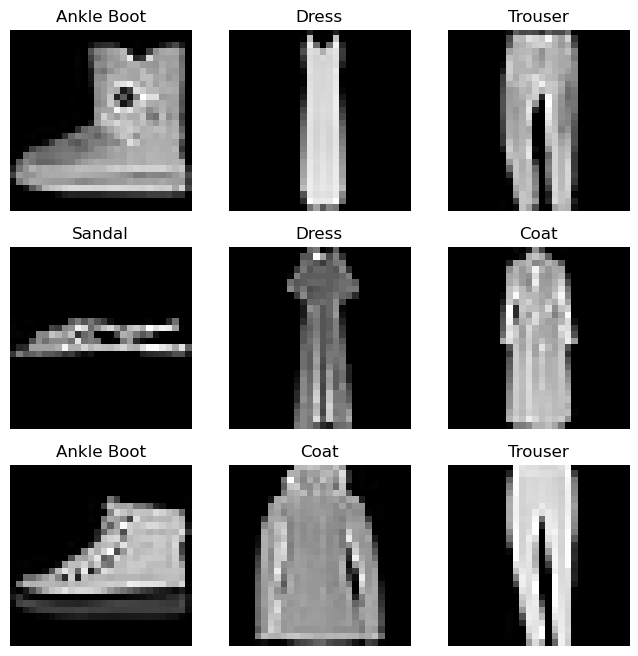

In [17]:
# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(), # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,)) # Normalize pixel values
])

# Download the training and testing datasets
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

# Create data loaders
batch_size = 64 # Feel free to play with this

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

#Let's see a sample of the training data
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(0, len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Run the Training


In [18]:
epochs = 5 #A typical training will involve a lot more epochs, but for demonstration purposes i'll keep it short
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.290299  [   64/60000]
loss: 0.609681  [ 6464/60000]
loss: 0.749833  [12864/60000]
loss: 0.609402  [19264/60000]
loss: 0.541104  [25664/60000]
loss: 0.324502  [32064/60000]
loss: 0.363463  [38464/60000]
loss: 0.374478  [44864/60000]
loss: 0.519624  [51264/60000]
loss: 0.400313  [57664/60000]
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.424580 

Epoch 2
-------------------------------
loss: 0.397284  [   64/60000]
loss: 0.466658  [ 6464/60000]
loss: 0.412603  [12864/60000]
loss: 0.231276  [19264/60000]
loss: 0.360087  [25664/60000]
loss: 0.460931  [32064/60000]
loss: 0.279574  [38464/60000]
loss: 0.154793  [44864/60000]
loss: 0.417327  [51264/60000]
loss: 0.481906  [57664/60000]
Test Error: 
 Accuracy: 85.6%, Avg loss: 0.390744 

Epoch 3
-------------------------------
loss: 0.379842  [   64/60000]
loss: 0.421258  [ 6464/60000]
loss: 0.411265  [12864/60000]
loss: 0.498947  [19264/60000]
loss: 0.330954  [25664/60000]
loss: 0.211228  [32064/600

## Seeing the Results (Inference)

Now that we have a trained model, let's see how it performs on some new images from the test dataset. We'll pick a random image and see what the model predicts.

Predicted: "Ankle Boot", Actual: "Ankle Boot"


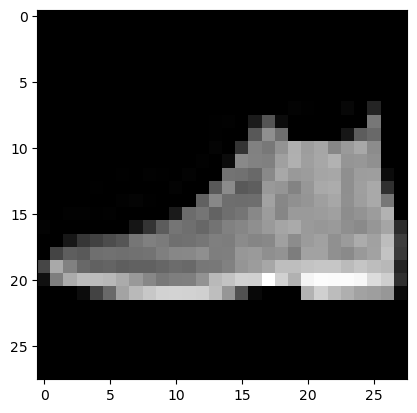

In [19]:
# Get a batch of test images
X, y = next(iter(test_dataloader))
X, y = X.to(device), y.to(device)

# Make predictions
model.eval() #Set the model to evaluation mode
with torch.no_grad():
    pred = model(X)
    predicted, actual = labels_map[pred.argmax(1)[0].item()], labels_map[y[0].item()]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

plt.imshow(X[0].cpu().squeeze(), cmap="gray")
plt.show()

## Saving the Model (Persistence)

Let's save our trained model so we can use it later without retraining.

In [20]:
torch.save(model.state_dict(), "fashion_model.pth")
print("Saved PyTorch Model State to fashion_model.pth")

Saved PyTorch Model State to fashion_model.pth


## Wrapping Up!

Congratulations! You've built and trained a fashion classification model using PyTorch and Codeanywhere. This is just the beginning. Experiment with different network architectures, training parameters, and datasets to create even more amazing AI applications!

## Further Reading
- [torch.nn API](https://pytorch.org/docs/stable/nn.html)